# MLEnd Mini Project
---------- 

# Overview
-----
This project is built upon the MLEnd dataset which is comprised of 20,000 audio samples of numbers provided by students at Queen Mary's University. 

This notebook is split into 2 primary sections, in which models will be built and tested to achieve different outcomes. This notebook was intended to run on Google Colab. 


1.   **Basic Solution**:

 A model is created to identify the intonation of a numeral contained in an audio file. Possible intonations are neutral, bored, excited or phrased as a question. The model will use hand-crafted features (primarily available through `sk-learn`) to create decision boundaries for 3 different types of classifiers; SVM, Gaussian Naive Bayes and K-nearest neighbours. Each classifier is evaluated using a validation dataset and different features are combined to try to maximise the accuracy of predictions. 


2.   **Advanced Solution**: 

 A model created to identify the numeral spoken, using a convolutional neural network to identify features from an mfcc spectogram. Once the model has been trained a potential real-world use case is discussed and demonstrated wherein the model is used to identify mobile numbers read out in an Interactive Voice Response (IVR) system.


# Environment set up
------

In this section we will set up a Colab environment for the MLEnd mini-project. 

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

import torch
from torch.utils import data
import torch.nn as nn

import os, sys, re, pickle, glob
import urllib.request
import zipfile

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 # 1. Basic Solution
 ------
 **Summary**
 
 For the basic solution the MLEnd dataset will be used to try to identify the intonation of the speaker. The possible intonations of each file are "neutral","bored","excited" and phrased as a question (Referred to as "question"). 
 
 This will be achieved by training a number of different classifiers and trialling different features to find an optimal solution. Since there are 4 potential categories of intonation a random classifier would be accurate 25% of the time. The aim of this section is to develop a classifier which produces the best results for a validation dataset (data which is not seen during training). 

## Dataset Preparation
-------

### Data download

The first few cells are used to download the dataset stored by Queen Mary University and save it within a personal Google drive. For convenience the download sections are stored within if statements to avoid multiple instances of downloads when running the notebook.



In [ ]:
path = '/content/drive/MyDrive/Data/MLEnd' # Path to store downloaded files
os.listdir(path) # Checking that the expected files are present

['trainingMLEnd.csv', 'training.zip', 'training']

In [ ]:
def download_url(url, save_path):
    "A function to download the content stored at a provided URL"
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

Downloading the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'

In [ ]:
if False: 
  url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
  save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
  download_url(url, save_path)

Unzipping the training file

In [ ]:
if False: 
  save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
  directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
  with zipfile.ZipFile(save_path, 'r') as zip_ref:
      zip_ref.extractall(directory_to_extract_to)

### Dataset visualisation
This section is used to visualise the dataset before preprocess or feature extraction. Further visualisation techniques will be applied once features have been extracted. 

* Viewing the total number of files in the available dataset

In [ ]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

* Below a tabular visualisation of the dataset is presented, giving a view of the different information stored for each file. 

* The csv file is read below and stored in a pandas dataframe. 

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


* This file consists of 20k rows and 4 columns. Each row corresponds to one of the items in our dataset, and each item is described by four attributes:


1.   File ID (audio file)
2.   Numeral
3.   Participand ID
4.   Intonation


* The below cells further explore the dataset and look at the number of samples per intonation and per numeral. 

In [ ]:
df = pd.DataFrame(labels)
numerals = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50,60,70,80,90,100,1000,1000000,1000000000]
intonations = ['excited','neutral','bored','question']
individuals = df.participant.unique()

numeral_count_dict = {}
intonation_count_dict = {}  
for i in numerals:
  count = len(df.loc[df['digit_label'] == i])
  numeral_count_dict[str(i)] = count 

for i in intonations:
  count = len(df.loc[df['intonation'] == i])
  intonation_count_dict[i] = count 



* The cells below give the counts for each intonation and numeral and have also been shown visually through bar charts for convenience. 

* There is an even split of intonation files and whilst there is some variance in the number of files for each numeral there are enough samples for this not to be a concern. 

{'excited': 5000, 'neutral': 5000, 'bored': 5000, 'question': 5000}
{'0': 655, '1': 663, '2': 652, '3': 650, '4': 641, '5': 650, '6': 668, '7': 638, '8': 653, '9': 663, '10': 609, '11': 596, '12': 601, '13': 598, '14': 639, '15': 620, '16': 569, '17': 614, '18': 625, '19': 585, '20': 622, '30': 640, '40': 618, '50': 606, '60': 617, '70': 638, '80': 605, '90': 595, '100': 625, '1000': 604, '1000000': 623, '1000000000': 618}


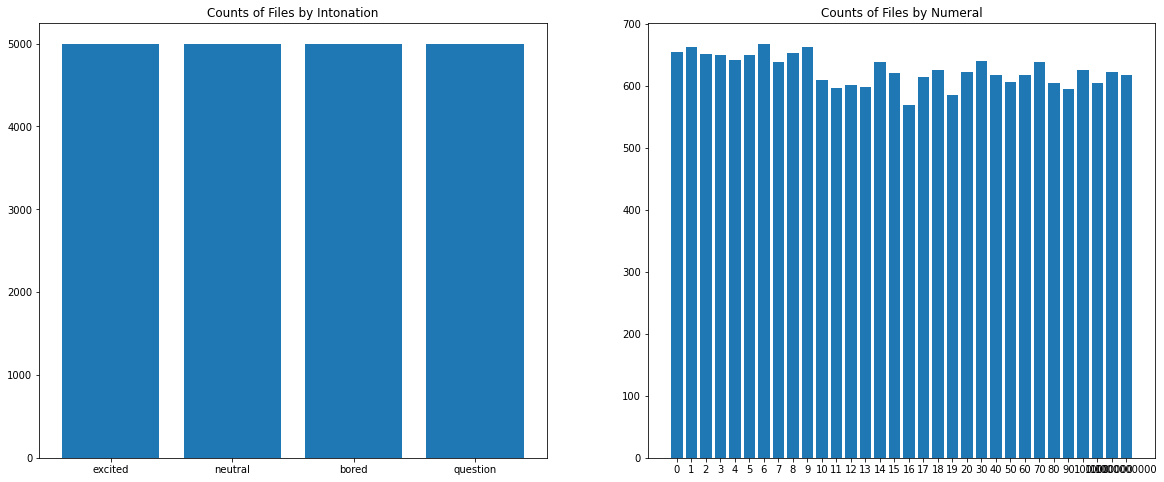

In [ ]:
print(intonation_count_dict)
print(numeral_count_dict)

fig, axs = plt.subplots(1,2, figsize = (20,8))
axs[0].bar(list(intonation_count_dict.keys()),intonation_count_dict.values())
axs[0].title.set_text('Counts of Files by Intonation')
axs[1].bar(list(numeral_count_dict.keys()), numeral_count_dict.values())
axs[1].title.set_text('Counts of Files by Numeral')

## Preprocessing & Feature Extraction 
---------

Since audio files are complex data types (time series) we will look to create a simpler feature representation for classification purposes. If raw information were to be used then we would have the number of attributes equal to the number of samples taken (An example of which is shown below). 


This magnitude of dimensionality is greater than the total number of samples we have available, and therefore presents a risk of overfitting. In order to address this we will look to use feature extraction as a way of significantly reducing this dimensionality.

In [ ]:
n=0
fs = None
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 26880 samples


In the sample information provided for this analysis, four features were defined to be extracted from the audio signals, namely:


1.   Power.
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.

In addition to these initial features a number of additional features will also be extracted to see what impact they have on predictions. 

The additional features to be introduced and tested include: 


1. Voiced power 
  * Power / fraction of voiced region 
1. Pitch change 
  * Average pitch over the first half of samples - average pitch over the second half of samples. 
  * This was introduced to target a raise in frequency for intonations such as "excited" and "question"
1. Spectral centroid information
  * A measure of the spectral "centre of mass" for each sample
  1. Spectral centroid mean 
  1. Spectral centroid standard deviation
1. MFCCs
  * Perceived frequency (based on human hearing)
  1. Mean 
  1. Standard deviation
1. Flatness 
  * A measure of how "noise-like" a sample is as apposed to being tonal. 
  * Expectation was this may be able to differentiate between "bored" intonation and others. 
  1. Mean 
  1. Standard deviation
  1. Maximum
1. Zero Crossings
  * The number of times the amplitude drops below the zero line, 
  1. Mean 
  1. Total

The majority of these features are extracted using functions and libraries made available by `librosa`. 

### Feature Extraction
Below two functions are created, one for getting pitch information from an audio sample, and another which will be used to return the frame and hop length to be used by other librosa functions. 


In [ ]:
def getPitch(x,fs,winLen=0.02):
  " A function used for extracting pitch and voice flags from an audio file"
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
def get_Audio_info(fs): 
  " A function for generating required audio features to be used in librosa functions"
  winLen = 0.02 
  p= winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  return frame_length, hop_length

Then next cell defines a function that takes a number of files and creates a NumPy array of all possible features as predictors (`X`) and their labels (`y`). 

In [ ]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  full_dataset = []
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    numeral = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and numeral >9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      # Pitch
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      frame_length, hop_length = get_Audio_info(fs)

      #spectral centroid features
      cent = librosa.feature.spectral_centroid(x, sr =fs)
      cent_mean = np.nanmean(cent)
      cent_std = np.nanstd(cent) 

      #MFCC features
      mfcc = librosa.feature.mfcc(y=x,sr=fs)
      mfcc_max = np.nanmax(mfcc)
      mfcc_mean = np.nanmean(mfcc)
      mfcc_std = np.nanstd(mfcc)

      # Flatness features
      flatness = librosa.feature.spectral_flatness(y=x, win_length= frame_length)
      flatness_mean = np.nanmean(flatness)
      flatness_std = np.nanstd(flatness)
      flatness_max = np.nanmax(flatness)

      # Zero crossings features
      zero_crossing_data = librosa.feature.zero_crossing_rate(x,frame_length=frame_length, hop_length=hop_length)
      zero_crossings = np.sum(zero_crossing_data)
      if zero_crossings > 100: zero_crossings = 100 # Capped due to a single outlier identified 
      zero_crossings_mean = np.mean(zero_crossing_data)
      
      # Pitch features
      power = np.sum(x**2)/len(x)
      pitch_range = np.nanmax(f0) - np.nanmin(f0)
      
      # Change in average pitch across audio file
      halfway_point = (len(f0)//2)
      pitch_change = np.nanmean(f0[0:halfway_point]) - np.nanmean(f0[halfway_point:])
      if math.isnan(pitch_change): 
        pitch_change = 0.0
      
      
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      # Calculate the total power over the voiced region of the audio file 
      if voiced_fr != 0:
        voiced_power = power / voiced_fr
      else: voiced_power = 0 

      # Return all features 
      xi = [cent, cent_mean, cent_std, mfcc, mfcc_max, mfcc_mean,mfcc_std, flatness, flatness_mean, flatness_std, flatness_max, zero_crossings, zero_crossings_mean, power, pitch_mean, pitch_range, pitch_std, voiced_fr, voiced_power, pitch_change]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

### Saving Extracted Features
----

The next cell is used to extract features for a specified number of examples. For efficiency the results are saved to drive for future testing. 

> Note that for demonstration purposes only 100 files are used in feature extration. For testing different classifiers and feature sets all 20,000 files are used. 

In [ ]:
file_size = 100
onlySingleDigit = False
X,y = getXy(files[:file_size],labels_file=labels,scale_audio=True, onlySingleDigit=onlySingleDigit)

# Defining paths to save numpy files to drive
X_path_string = '/content/drive/MyDrive/Data/features_X_' + str(file_size)
y_path_string = '/content/drive/MyDrive/Data/labels_y_' + str(file_size)

# Altering the path to reference single digits or all digits
if onlySingleDigit: 
  X_path_string += 'SD.npy'
  y_path_string += 'SD.npy'
else: 
  X_path_string += '.npy'
  y_path_string += '.npy'

# Saving the np files 
np.save(X_path_string, X, allow_pickle=True)
np.save(y_path_string, y, allow_pickle=True)

print(f"\nX features saved as: {X_path_string}")
print(f"y labels saved as: {y_path_string}")

100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


X features saved as: /content/drive/MyDrive/Data/features_X_100.npy
y labels saved as: /content/drive/MyDrive/Data/labels_y_100.npy



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### Loading Previously Extracted Features 
----
As previously noted, extracted features have been saved to drive to avoid the feature extraction process having to be run every time the notebook is accessed. The cell below loads the files (if they're available) for a specified size and for single numerals or all numerals. 

In [ ]:
def load_basic_model_data(file_size, single_digit_only): 
  # Generates the expected path for the file size and single digit setting provided
  X_path = '/content/drive/MyDrive/Data/features_X_' + str(file_size)
  y_path = '/content/drive/MyDrive/Data/labels_y_' + str(file_size)

  if single_digit_only == True: 
    X_path += 'SD.npy'
    y_path += 'SD.npy'
  else: 
    X_path += '.npy'
    y_path += '.npy'

  print(X_path)
  print(y_path)
  
  # If the file does not exist an error message is returned
  try: 
    X = np.load(X_path, allow_pickle=True)
    y = np.load(y_path, allow_pickle = True)
  except: 
    print("File not found for desired size")
    return None, None
  
  return X,y

In [ ]:
# Loading the features extracted from all 20,000 files and for all digits
X, y = load_basic_model_data(20000,False)

/content/drive/MyDrive/Data/features_X_20000.npy
/content/drive/MyDrive/Data/labels_y_20000.npy


In [ ]:
# Demonstrating the shape of the X (predictors) and y (labels) arrays returned.
print(X.shape)
print(y.shape)

(20000, 20)
(20000,)


### Feature Selection
Since preprocessing is a largely time consuming process a decision has been made to initially extract all features once before selecting subsets of features to be used in the training and validation stages. Each time a different feature set is used the validation and training set is regenerated from the 20,000 available samples to ensure there is no risk of overfitting from a single set of training data. 


The feature dictionary shown in the next cell indicate all of the possible features available and the numbers are used to represent the index of the column in which they are stored in the returned array X. 


In [ ]:
feature_dict = {
    # Feature name : Index
    'cent': 0,
    'cent_mean': 1, 
    'cent_std': 2,
    'mfcc': 3,
    'mfcc_max':4,
    'mfcc_mean':5,
    'mfcc_std': 6,
    'flatness':7,
    'flatness_mean':8,
    'flatness_std':9,
    'flatness_max':10, 
    'zero_crossings':11, 
    'zero_crossings_mean':12, 
    'power':13,
    "pitch_mean":14,
    'pitch_range':15,
    'pitch_std':16, 
    'voiced_fr':17,
    'voiced_power':18,
    'pitch_change':19
}

### Visualising Features 
---- 

The next couple of cells were used to view the separation of individual features in the predictor space and also to view the mean values based on each intonation. 

A visual inspection of individual features was used to inform which features were prioritised in developing the model. 

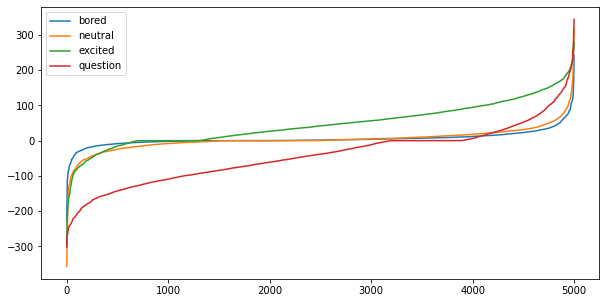

<BarContainer object of 4 artists>

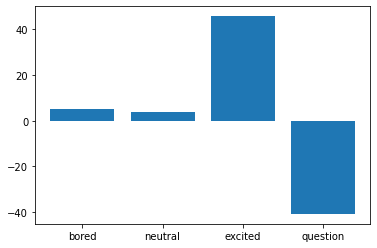

In [ ]:
columns = ['bored','neutral','excited','question']
feature_1 = [x[feature_dict['pitch_change']] for x in X]
bored=[]
excited = []
question = []
neutral = []

# Creating lists of featues divided into intonation groups 
for i in range(len(y)): 
  if y[i] == 'bored':
    bored.append(feature_1[i])
  elif y[i] == 'excited': 
    excited.append(feature_1[i])
  elif y[i] == 'neutral': 
    neutral.append(feature_1[i])
  elif y[i] == 'question': 
    question.append(feature_1[i])

# Sorting lists for clarity
# Since these are single features changing the order should not impact visualisations
bored = sorted(bored)
question = sorted(question)
excited = sorted(excited)
neutral = sorted(neutral)

# Plotting the sorted lists 
fig, ax = plt.subplots(1, figsize = (10,5))
plt.plot(bored, label = 'bored')
plt.plot(neutral, label = 'neutral')
plt.plot(excited, label = 'excited')
plt.plot(question, label = 'question')
plt.legend()
plt.show()

# Plotting the mean of each category for the specified feature
plt.bar(columns, [np.mean(bored),np.mean(neutral),np.mean(excited),np.mean(question)])

An example of visualising a single feature is shown above for 'pitch_change'. Additional commentary for other features is captured below
* **mfcc_max** values separates 'excited' samples from other intonations 
* In the majority of samples **mfcc_mean** provides a degree of separation between bored and neutral compared to excited and question 
* The mean values of **power** over all samples are significantly different for neutral/question compared to bored / excited 
* **Pitch mean and std** provides clear separation for all intonations when values are sorted. 
* **Voiced_fr** provides good separation for excited samples when values are sorted.  
* **Voiced power** does not provide any useful degree of separation, rather it seems to collapse the different intonations into similar values 
* The means for **pitch_change** give the greatest variability of all samples, particularly for excited and question intonations 
* Other features not specifically referenced were not deemed to provide a good separation of different intonations. 

With an initial view of individual features completed, the cell below was used to compared pairs of predictors in an attempt to identify those which work well together to provide clear decision boundaries. Only the first 100 samples of each feature are taken to avoid creating a scatter plot with too many data points. 


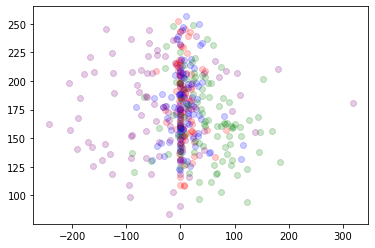

In [ ]:
columns = ['bored','neutral','excited','question']
feature_1 = [x[feature_dict['pitch_change']] for x in X]
feature_2 = [x[feature_dict['mfcc_max']] for x in X]
bored=[]
excited = []
question = []
neutral = []

for i in range(len(y)): 
  if y[i] == 'bored':
    if len(bored) < 100:
      bored.append((feature_1[i],feature_2[i]))
  elif y[i] == 'excited': 
    if len(excited) < 100:
      excited.append((feature_1[i],feature_2[i]))
  elif y[i] == 'neutral': 
    if len(neutral)< 100: 
      neutral.append((feature_1[i],feature_2[i]))
  elif y[i] == 'question': 
    if len(question)<100:
      question.append((feature_1[i],feature_2[i]))

bored1 = [bored[i][0] for i in range(len(bored))]
bored2 = [bored[i][1] for i in range(len(bored))]

n1 = [neutral[i][0] for i in range(len(neutral))]
n2 = [neutral[i][1] for i in range(len(neutral))]

q1 = [question[i][0] for i in range(len(question))]
q2 = [question[i][1] for i in range(len(question))]

e1 = [excited[i][0] for i in range(len(excited))]
e2 = [excited[i][1] for i in range(len(excited))]

plt.scatter(bored1,bored2,alpha = 0.2, c='red')
plt.scatter(n1,n2,alpha = 0.2, c='blue')
plt.scatter(e1,e2,alpha = 0.2, c='green')
plt.scatter(q1,q2,alpha = 0.2, c='purple')


Since the model will be dependent on multiple features it is difficult to identify which features will create the best decision boundaries. The example above shows how a decision boundary could be drawn to classify excited (green) and question (purple) samples, with decent accuracy. However, another feature would be required to further differentiate between other intonations such as bored and neutral.

The next cell uses the feature_dict dictionary  to reduce the features down to only the desired feature set to be used in testing. 

* Throughout the testing process those features which were identified in the visualisation stage as providing a good separation between different intonations were prioritised. 

* Features were added and removed sequentially to test the impact on performance. 

In [ ]:
# Create a list of the desired features to be extracted from the dataset
desired_features = ['power','pitch_mean','pitch_std','voiced_fr','pitch_change', 'mfcc_max','mfcc_mean','flatness_mean','zero_crossings']
indices = [] 
# Extract the indices from the dictionary of the desired features
for i in desired_features: 
  indices.append(feature_dict[i])

# Create a sample of X which only contains the desired features
X_sample = X[:,indices]
X_sample = np.array(X_sample, dtype='float64')

The next cell shows the shape of the new feature set `X (sample)` and `y` and prints the labels vector `y`:

In [ ]:
print('The shape of X (sample) is', X_sample.shape) 
print('The shape of y (sample) is', y.shape)
print('The labels vector is', y)

The shape of X (sample) is (20000, 9)
The shape of y (sample) is (20000,)
The labels vector is ['bored' 'question' 'excited' ... 'excited' 'bored' 'bored']


Finally, to be on the cautious side, any items which include a NaN (*not a number*) value are removed from the dataset. 

If any NaN values are identified then the number of files removed from the dataset is printed. 

In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X_sample)):
  print(f"Removing {np.sum(np.isnan(X))} files")
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X_sample)))

0


## Modeling
-------
In this section the different models to be used in the classification task to predict the intonation of the numerals being spoken are introduced before moving onto training and validation.

### Types of models to be used

#### Support Vector Machine

The first model which will be used is a support vector machine (SVM). The SVM will identify the best possible hyperplanes to separate the feature representations provided at the training stage. These hyperplanes are then used to categorise any new observations seen. 

The SVM method used is provided by provided by `scikit-learn` 

#### Gaussian Naive Bayes
Naive bayes is a probabilistic classifier which (naively) assumes independence of all predictors. In a Gaussian Naive Bayes model the training data is used to create Gaussian distributions to represent the labelled training data. When new observations are made the sample is assigned to the Gaussian distribution with the highest probability. 

The Gaussian Naive Bayes classifier used is again provided by `scikit-learn`

#### K-Nearest Neighbour Classifier

A K-nearest Neighbour classifier is a relatively simple classifier whereby any new observations are compared to their nearest K neighbours which are labelled. The new sample is then assigned to the class which the majority of its labeled neighbours belong to. 

The K-Nearest Neighbour classifier used is also provided by `scikit-learn`.



### Training and Validation

Packages available from sci-kit learn to split the dataset defined by `X` and `y` into a training set and a validation set.

Note that this step is repeated every time a new feature set is taken from all of the available features as shown previously. 

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix # To be used in validation


print(X_sample.shape)

# Generating a training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_sample,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape # demonstrating the split of training and validation datasets

(20000, 9)


((14000, 9), (6000, 9), (14000,), (6000,))

In the next cell the different classifiers are fitted using the training data before computing the accuracy on the validation data. 

In [ ]:
# Initialisation of the SVM classifier
model_SVM  = svm.SVC(C=1)
model_SVM.fit(X_train,y_train) # Fitting the SVM model to the training data

# Initialisation of the Gaussian Naive Bayes (GNB) classsifier 
model_GNB = GaussianNB()
model_GNB.fit(X_train, y_train) # Fitting the GNB classifier to the training data

# Initialisation of the K-Nearest Neighbour (KNN) classifier 
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train,y_train) # Fitting the KNN classifier to the training data

# Predicting the classes of samples from training and validation sets using the SVM classifier
yt_p = model_SVM.predict(X_train)
yv_p = model_SVM.predict(X_val)

# Predicting the classes of samples from training and validation sets using the GNB classifier
yt_p2 = model_GNB.predict(X_train)
yv_p2 = model_GNB.predict(X_val)

# Predicting the classes of samples from training and validation sets using the KNN classifier
yt_p3 = knn_classifier.predict(X_train)
yv_p3 = knn_classifier.predict(X_val)

# Printing te accuracy for the Validation accuracy only to gauge the success of each model
#print('SVM Training Accuracy', np.mean(yt_p==y_train))
print(f'SVM Validation  Accuracy: {100*np.mean(yv_p==y_val):.1f}%')


#print('GNB Training Accuracy', np.mean(yt_p2==y_train))
print(f'GNB Validation  Accuracy: {100*np.mean(yv_p2==y_val):.1f}%')

#print('KNN Training Accuracy', np.mean(yt_p3==y_train))
print(f'KNN Validation  Accuracy:  {100*np.mean(yv_p3==y_val):.1f}%')

SVM Validation  Accuracy: 58.8%
GNB Validation  Accuracy: 55.2%
KNN Validation  Accuracy:  59.4%


### Performance Evaluation
In the next cell three confusion matrices are plotted to visualise which classes are being confused by the classifiers. A confusion matrix is plotted for each classifier used. 

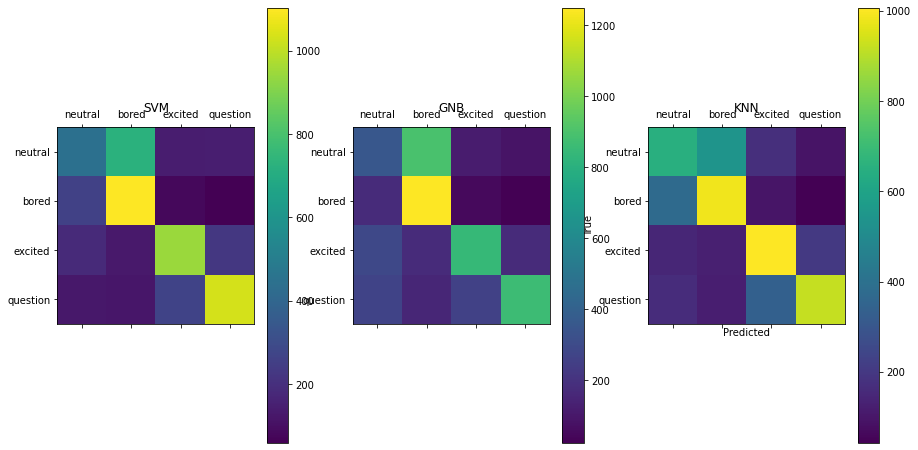

In [ ]:
cm_labels = ['neutral','bored','excited','question']
cm = confusion_matrix(y_val,yv_p, labels = cm_labels) # Confusion matrix for SVM classifier
cm2 = confusion_matrix(y_val,yv_p2, labels = cm_labels) # Confusion matrix for GNB classifier
cm3 = confusion_matrix(y_val,yv_p3, labels = cm_labels) # Confusion matrix for KNN classifier

# Setting up figure and subplots to display the confusion matrices
fig, ax = plt.subplots(1,3, figsize = (15,8))
cax = ax[0].matshow(cm)
ax[0].set_xticklabels([''] + cm_labels)
ax[0].set_yticklabels([''] + cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar(cax,ax=ax[0])

cax2 = ax[1].matshow(cm2)
ax[1].set_xticklabels([''] + cm_labels)
ax[1].set_yticklabels([''] + cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar(cax2,ax=ax[1])

cax3 = ax[2].matshow(cm3)
plt.colorbar(cax3,ax=ax[2])
ax[2].set_xticklabels([''] + cm_labels)
ax[2].set_yticklabels([''] + cm_labels)
ax[0].title.set_text('SVM')
ax[1].title.set_text('GNB')
ax[2].title.set_text('KNN')

plt.show()

In this section we will retrain the classifiers with the predictors normalised to see if performance improves.

Z-score normalisation will be applied here to create a distribution with 0 mean and unit variance 

$$ x' = \frac{x-\mu}{\sigma}$$

In [ ]:
# Calculating the mean and standard deviation
mean = X_train.mean(0) 
sd =  X_train.std(0)

X_train_n = (X_train-mean)/sd
X_val_n  = (X_val-mean)/sd

model_SVM  = svm.SVC(C=1,gamma=2)
model_SVM.fit(X_train_n,y_train)

model_GNB = GaussianNB()
model_GNB.fit(X_train_n, y_train)

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_n,y_train)

yt_p = model_SVM.predict(X_train_n)
yv_p = model_SVM.predict(X_val_n)

yt_p2 = model_GNB.predict(X_train_n)
yv_p2 = model_GNB.predict(X_val_n)

yt_p3 = knn_classifier.predict(X_train_n)
yv_p3 = knn_classifier.predict(X_val_n)

#print('SVM Training Accuracy', np.mean(yt_p==y_train))
print(f'SVM Validation  Accuracy: {100*np.mean(yv_p==y_val):.1f}%')


#print('GNB Training Accuracy', np.mean(yt_p2==y_train))
print(f'GNB Validation  Accuracy: {100*np.mean(yv_p2==y_val):.1f}%')

#print('KNN Training Accuracy', np.mean(yt_p3==y_train))
print(f'KNN Validation  Accuracy:  {100*np.mean(yv_p3==y_val):.1f}%')

SVM Validation  Accuracy: 67.4%
GNB Validation  Accuracy: 55.3%
KNN Validation  Accuracy:  64.3%


Again, we will print out three confusion matrices to identify which classes are being confused. 

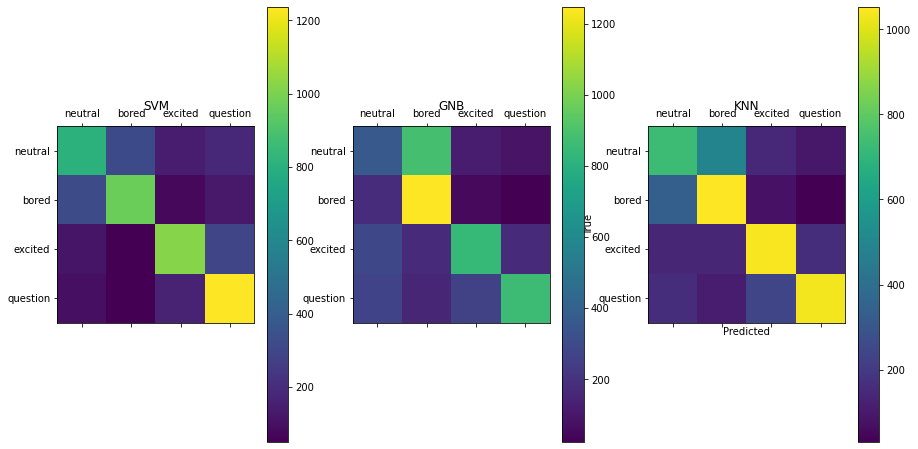

In [ ]:
# Printing of confusion matrices
cm_labels = ['neutral','bored','excited','question']
cm = confusion_matrix(y_val,yv_p, labels = cm_labels)
cm2 = confusion_matrix(y_val,yv_p2, labels = cm_labels)
cm3 = confusion_matrix(y_val,yv_p3, labels = cm_labels)
fig, ax = plt.subplots(1,3, figsize = (15,8))
cax = ax[0].matshow(cm)
#fig.colorbar(cax)
ax[0].set_xticklabels([''] + cm_labels)
ax[0].set_yticklabels([''] + cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
cax2 = ax[1].matshow(cm2)
ax[1].set_xticklabels([''] + cm_labels)
ax[1].set_yticklabels([''] + cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
##fig.colorbar(cax2)
plt.colorbar(cax,ax=ax[0])
plt.colorbar(cax2,ax=ax[1])
cax3 = ax[2].matshow(cm3)
plt.colorbar(cax3,ax=ax[2])
ax[2].set_xticklabels([''] + cm_labels)
ax[2].set_yticklabels([''] + cm_labels)
ax[0].title.set_text('SVM')
ax[1].title.set_text('GNB')
ax[2].title.set_text('KNN')
plt.show()

* Note that whilst the KNN classifier may appear to be the best it is using a different scale than the SVM classifier, which achieves the highest accuracy on the validation dataset 
* The SVM confusion matrix shows that excited and question are most often confused with one another, whilst the same is also true for neutral and bored intonations. 

#### Tracking of results with different features 
----

The table below shows the different accuracies achieved using the different classifiers and feature sets. All 20,000 files were used with 30% of them making up a validation dataset.

* Note that whilst only the validation accuracies are shown in the table, the confusion matrices were referred to throughout the testing process to identify the classes which were being confused with one another
* Validation accuracies are shown for both unnormalised and normalised (N) predictors. 
* Features are added incrementally in an attempt to improve validation performance.

| SVM | GNB | KNN | SVM (N) | GNB (N) | KNN (N) | Features Used | 
|--|--|--|--|--|--|--|
|47 |47 |45 |55 |47 |50 |Power, pitch mean, pitch std, voiced fr |
|47 |47 |45 |55 |47 |51 |pitch mean, pitch std, voiced fr |
|55 |54 |56 |61 |53 |58 |pitch mean, pitch std, voiced fr, pitch change|
|56 |53 |56 |62 |53 |57 |pitch mean, pitch std, voiced fr, pitch change, mfcc max |
|55 |52 |56 |62 |56 |59 |pitch mean, pitch std, voiced fr, pitch change, mfcc max, mfcc mean|
|57 |54 |57 |63 |54 |60 |Power,pitch mean, pitch std, voiced fr, pitch change, mfcc max, mfcc mean|
|56 |53 |57 |66 |53 |63 |Power,pitch mean, pitch std, voiced fr, pitch change, mfcc max, mfcc mean, flatness mean|
|57 |53 |57 |65 |53 |62 |Power,pitch mean, pitch std, voiced fr, pitch change, mfcc max, mfcc mean, flatness std|
|57 |55 |57 |63|55 |61 |Power,pitch mean, pitch std, voiced fr, pitch change, mfcc max, mfcc mean, flatness max|
|58|54 |59 |67 |54 |65 |Power,pitch mean, pitch std, voiced fr, pitch change, mfcc max, mfcc mean, flatness mean, zero crossings total |
|56|54 |59 |65 |54 |64 |Power,pitch mean, pitch std, voiced fr, pitch change, mfcc max, mfcc mean, flatness mean, zero crossings mean   |
|52 |54 |55 |67 |54 |65 |Power,pitch mean, pitch std, voiced fr, pitch change, mfcc max, mfcc mean, flatness mean, zero crossings total, central spectroid mean |
|53 |53 |53 |65 |54 |65 |Power,pitch mean, pitch std, voiced fr, pitch change, mfcc max, mfcc mean, flatness mean, zero crossings total, central spectroid std |

## Conclusion
-----
In this first 'basic solution' three types of classifiers have been used with varying feature sets to try to improve the validation accuracy of classifying the intonation of numerals spoken. 

The confusion matrices show that all of the classifiers struggle to distinguish between "bored" and "neutral" intonations and also between "excited" and "question" intonations. This may be expected as it is often difficult to distinguish between these groups of intonations even as a human.  

Normalisation of predictors had a large impact on the validation accuracy obtained by the classifiers. 

The best classifier identified in the testing section was an SVM classifier using the following (normalised) features: 
* power
* pitch mean
* pitch std
* voiced fr
* pitch change
* mfcc max
* mfcc mean 
* flatness mean
* zero crossings total

Interestingly, certain features which were not expected to be useful in classification (such as flatness and zero crossings) provided some benefit beyond the promising features identified in the data visualisation stage. 

This combination of features led to a validation accuracy of c. 67% when using the SVM classifier, which consistently provided the best results.

The final cell for this section (below) trains the classifier using the entire dataset, ready to be used for alternative test sets. 


In [ ]:
# Normalisation of features 
mean = X_sample.mean(0) 
sd =  X_sample.std(0)
X_sample_n = (X_sample - mean)/sd 

# Demonstrating the number of features and samples
print(X_sample_n.shape, y.shape)

# Fitting to the whole dataset 
model_SVM  = svm.SVC(C=1,gamma=2)
model_SVM.fit(X_sample_n,y)
print("Model Trained on full dataset")

(20000, 9) (20000,)
Model Trained on full dataset


# 2. Advanced Solution 
--------
The basic and advanced solutions take very different approaches with regards to predicting a label. Whereas the basic solution extracts multiple features to predict an intonation, the advanced solution focuses on the Mel Frequency Cepstral Co-efficients (MFCCs) returned by each window of an audio sample to predict the numeral which is being spoken. The combination of MFCCs make up a mel frequency cepstrum, which is a representation of the short term power-sprectrum of a sound. 

Once the MFCCs have been extracted they are combined into a matrix of a fixed size, with clipping or padding applied to achieve the desired size where required. 

These matrices are then fed into a convolutional neural network which uses deep learning to identify features which can best identify each numeral. This approach is similar to techniques used in computer vision, however in this instance each 'image' is a series of MFCCs returned in a time series. 

## Dataset Preparation
-------
Dataset preparation will largely follow the same steps as those which have been applied for the basic solution

### Data download

The first few cells are used to download the dataset which is stored by Queen Mary University and to save it within a personal Google drive. For convenience the download sections are stored within if statements to avoid multiple instances of downloads when running the notebook.



In [ ]:
path = '/content/drive/MyDrive/Data/MLEnd' # Path to store downloaded files
os.listdir(path)

['trainingMLEnd.csv', 'training.zip', 'training']

In [ ]:
def download_url(url, save_path):
    "A function to download the content stored at a provided URL"
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

Downloading the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'

In [ ]:
if False: 
  url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
  save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
  download_url(url, save_path)

Unzipping the training file

In [ ]:
if False: 
  save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
  directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
  with zipfile.ZipFile(save_path, 'r') as zip_ref:
      zip_ref.extractall(directory_to_extract_to)

### Dataset visualisation

Below a tabular visualisation of the dataset is presented, giving a view of the different information stored for each file. 

The csv file is read in below and stored in a pandas dataframe. 

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


This file consists of 20k rows and 4 columns. Each row corresponds to one of the items in our dataset, and each item is described by four attributes:


1.   File ID (audio file)
2.   Numeral
3.   Participand ID
4.   Intonation


The below cells further explore the dataset and look at the number of samples per intonation and per numeral. 

In [ ]:
df = pd.DataFrame(labels)
numerals = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50,60,70,80,90,100,1000,1000000,1000000000]
intonations = ['excited','neutral','bored','question']
individuals = df.participant.unique()

numeral_count_dict = {}
intonation_count_dict = {}  
for i in numerals:
  count = len(df.loc[df['digit_label'] == i])
  numeral_count_dict[str(i)] = count 

for i in intonations:
  count = len(df.loc[df['intonation'] == i])
  intonation_count_dict[i] = count 

The cells below give the counts for each intonation and numeral and have also been shown visually through bar charts for convenience. 

There is an even split of intonation files and whilst there is some variance in the number of files for each numeral there are enough samples for this not to be a concern. 

{'excited': 5000, 'neutral': 5000, 'bored': 5000, 'question': 5000}
{'0': 655, '1': 663, '2': 652, '3': 650, '4': 641, '5': 650, '6': 668, '7': 638, '8': 653, '9': 663, '10': 609, '11': 596, '12': 601, '13': 598, '14': 639, '15': 620, '16': 569, '17': 614, '18': 625, '19': 585, '20': 622, '30': 640, '40': 618, '50': 606, '60': 617, '70': 638, '80': 605, '90': 595, '100': 625, '1000': 604, '1000000': 623, '1000000000': 618}


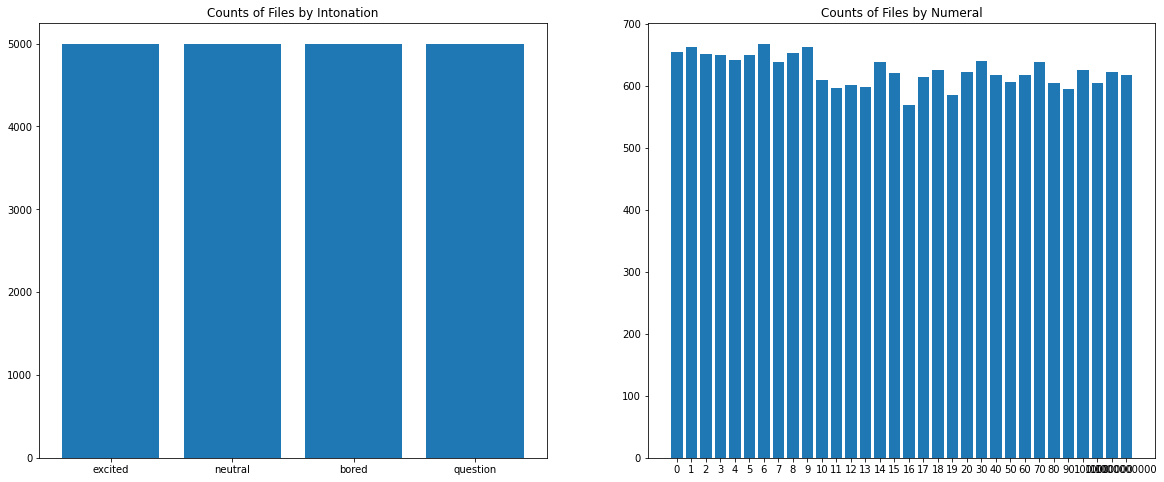

In [ ]:
print(intonation_count_dict)
print(numeral_count_dict)

fig, axs = plt.subplots(1,2, figsize = (20,8))
axs[0].bar(list(intonation_count_dict.keys()),intonation_count_dict.values())
axs[0].title.set_text('Counts of Files by Intonation')
axs[1].bar(list(numeral_count_dict.keys()), numeral_count_dict.values())
axs[1].title.set_text('Counts of Files by Numeral')

## Preprocessing & Feature Extraction 
---------

### Feature Extraction

As outlined in the introduction, the advanced solution will focus on MFCCs extracted from each audio file. The next cell defines a function that takes a number of files and creates a NumPy array which captures the MFCC values for 100 frames. 

Since audio files are of varying length, they must be padded or clipped to ensure all features returned are of the same shape (required for a neural network).

 A value of 100 frames was used to ensure that the majority of audio files were not clipped, to ensure that information was not lost, except for exceptionally long files. To choose an appropriate value the maximum and minimum length of returned mfcc values were recorded and the distribution plotted. 

In [ ]:
mfcc_len_tracker = []
def getXy_mfcc(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  full_dataset = []
  mfcc_samples_max = 0 
  mfcc_samples_min = 10000

  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and yi >9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))

      #MFCC
      mfcc = librosa.feature.mfcc(y=x,sr=fs)
      
      # Tracking the length of MFCCs
      if mfcc.shape[1] > mfcc_samples_max: 
        mfcc_samples_max = mfcc.shape[1]
      if mfcc.shape[1] < mfcc_samples_min: 
        mfcc_samples_min = mfcc.shape[1]
      mfcc_len_tracker.append(mfcc.shape[1])
      
      # Sample size determined by assessment of mfcc lengths returned
      sample_size = 100

      # Padding / Clipping returned MFCC
      if mfcc.shape[1] < sample_size:
        mfcc_shape = np.shape(mfcc)
        mfcc_tx =  np.zeros((20,sample_size)) 
        mfcc_tx[:mfcc_shape[0], :mfcc_shape[1]] = mfcc
        #print("PADDING")
      else: 
        mfcc_tx = mfcc[:,:sample_size]
        #print("CLIPPING")


      mfcc_tx = np.matrix.transpose(mfcc_tx)

      xi = [mfcc_tx]
      X.append(xi)
      y.append(yi)
  return np.array(X),np.array(y)

### Saving Extracted Features 
----
Similarly to the basic solution, extracted features were saved to drive to remove the requirement to extract features multiple times. 

500 files have features extracted in the cell below for demonstration purposes. In practice all 20,000 files were used (with those files later split into training and validation datasets). 

In [ ]:
file_size = 500
onlySingleDigit =False
X_adv,y_adv = getXy_mfcc(files[:file_size],labels_file=labels,scale_audio=True, onlySingleDigit=onlySingleDigit)

X_path_string = '/content/drive/MyDrive/Data/mfcc_X_' + str(file_size)
y_path_string = '/content/drive/MyDrive/Data/mfcc_y_' + str(file_size)



if onlySingleDigit: 
  X_path_string += 'SD.npy'
  y_path_string += 'SD.npy'
else: 
  X_path_string += '.npy'
  y_path_string += '.npy'

np.save(X_path_string, X_adv, allow_pickle=True)
np.save(y_path_string, y_adv, allow_pickle=True)
  

100%|██████████| 500/500 [00:08<00:00, 58.92it/s]


As previously mentioned a fixed frame size is required when using a convolutional neural network. Below the distribution of the number of MFCC frames returned for each audio file is plotted, providing justification for the value of 100 used. 

Text(0.5, 1.0, 'Distribution of the number of MFCC frames returned')

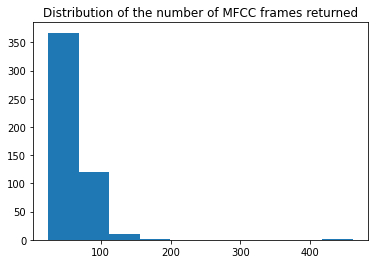

In [ ]:
# Plotting the distribution of the number of MFCC frames returned for each audio file
# 100 was chosen as the fixed size as the vast majority of files are shorter than that limit 
plt.hist(mfcc_len_tracker)
plt.title('Distribution of the number of MFCC frames returned')

### Loading Previously Extracted Features 
----- 
The function below is used to load previously saved files containing the features extracted for a specified number of files, and whether it requires only single numerals or all numerals. 

In [ ]:
def load_adv_model_data(filesize, single_digit_only): 
  X_path = '/content/drive/MyDrive/Data/mfcc_X_' + str(filesize)
  y_path = '/content/drive/MyDrive/Data/mfcc_y_' + str(filesize)

  if single_digit_only == True: 
    X_path += 'SD.npy'
    y_path += 'SD.npy'
  else: 
    X_path += '.npy'
    y_path += '.npy'
  
  try:
    X_adv = np.load(X_path, allow_pickle=True)
    y_adv = np.load(y_path, allow_pickle = True)
  except: 
    print("File not found for specified filesize")
    return None, None
  
  return X_adv, y_adv

In [ ]:
X_adv, y_adv = load_adv_model_data(20000, False)
print(X_adv.shape, y_adv.shape) # Demonstrating the successful loading of previously saved data

(20000, 1, 100, 20) (20000,)


## Data visualisation 
The cell below generates an example of the MFCC spectogram returned after feature extraction. This spectogram will act as an image from which the convolutional neural network will look to extract features to be used in classification. 

Each pixel in the graph shown represents a numerical value returned as an element of an MFCC frame. The convolutional neural network used will look to identify certain features across the entirety of the image to be used in classification. 

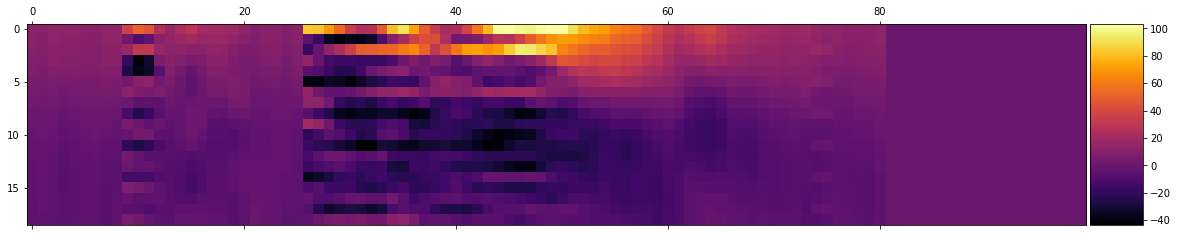

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


example = X_adv[5]
example = example.squeeze()
example = example.transpose()
# For demonstration purposes the first row has been removed as it is always a large negative number which impacts the colour scaling
example = example[1:,:] 
fig, ax = plt.subplots(1,1, figsize = (20,20))
cax = ax.matshow(example, cmap = 'inferno')
divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(cax, cax=cbar)

## Training and Validation
----
The cells below were used to generate training and validation datasets to be used in the deep learning model. This model is built using the foundations made available by `pytorch`. 

In [ ]:
# Removing unnecessary dimensions
X_adv = X_adv.squeeze()

# Converting Numpy arrays into tensor
Xt = torch.tensor(X_adv)
yt = torch.tensor(y_adv)

# Splitting tensors into training and validation datasets
val_split = 0.8
split_index = int(Xt.shape[0] * val_split)
Xt_train = Xt[:split_index,:,:]
Xt_val = Xt[split_index:,:,:]
yt_train = yt[:split_index]
yt_val = yt[split_index:]

# Demonstrating the split between validation and training datasets
Xt_train.shape, yt_train.shape, Xt_val.shape, yt_val.shape

(torch.Size([16000, 100, 20]),
 torch.Size([16000]),
 torch.Size([4000, 100, 20]),
 torch.Size([4000]))

In [ ]:
# Creating Tensor Dataset objects for deep learning pipleline
train_dataset = data.TensorDataset(Xt_train,yt_train)
val_dataset = data.TensorDataset(Xt_val, yt_val) 

batch_size = 32 
train_iter = data.DataLoader(train_dataset,batch_size, shuffle = True)
val_iter = data.DataLoader(val_dataset,batch_size, shuffle = True)

### Neural Network
--- 
The below cell creates a new class which defines the neural network which will be used for this classification task. 

The neural network initially consisted of 2 convolutional layers and 3 fully connected linear layers. During training the number of layers may have changed to see if it had a positive impact on performance. 

In [ ]:
class conv_net(torch.nn.Module):
  def __init__(self, num_outputs):
    super(conv_net, self).__init__()
    self.num_inputs = (100,20)
    self.num_outputs = num_outputs

    self.conv1 = nn.Conv2d(1,12,3,1,padding=1)
    self.pool1 = torch.nn.AvgPool2d(2,2,0)
    self.conv2 = nn.Conv2d(12,32,3,1, padding = 1)
    self.pool2 = torch.nn.AvgPool2d(2,2,0)
    
    self.conv3 = nn.Conv2d(32,64,3,1, padding = 1)
    self.pool3 = torch.nn.AvgPool2d(2,2,0)


    self.Linear1 = nn.Linear(1536, 400)
    self.Linear2 = nn.Linear(400, 120)
    self.Linear3 = nn.Linear(120,num_outputs)

  def forward(self, x):
      x = torch.relu(self.conv1(x))
      x = (self.pool1(x))
      x = torch.relu(self.conv2(x))        
      x = (self.pool2(x))
      x = torch.relu(self.conv3(x))        
      x = (self.pool3(x))
      reshape = x.shape[1]*x.shape[2]*x.shape[3]
      x = x.view(-1,reshape)
      x = torch.relu(self.Linear1(x))
      x = torch.relu(self.Linear2(x))
      out = self.Linear3(x)
      return out

In the cell below the initial weights of the parameters used in the model are initialised randomly. 

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)          

num_outputs = 32 # 32 outputs needed if classifiying all digits 
# num_outputs = 10 # Uncomment if using single digits only

# Initialising the neural network
model = conv_net(num_outputs)

# Initialising the weights 
model.apply(init_weights);
print(model)

conv_net(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (Linear1): Linear(in_features=1536, out_features=400, bias=True)
  (Linear2): Linear(in_features=400, out_features=120, bias=True)
  (Linear3): Linear(in_features=120, out_features=32, bias=True)
)


#### Defining the loss and optimizer

In the cell below the type of loss is selected, along with the optimization algorithm to be used. The type of loss used is Cross Entropy Loss. Different optimizers will be used to identify the best solution. 

In [ ]:
loss = nn.CrossEntropyLoss()
lr = 0.01
wd = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

#### Main Training Loop
----
The cell below provides the main training loop to be used as part of the deep learning process. 

Note that a label encoder is used to map numerals to a consistent set of labels. 

In [ ]:
def train_model(net, train_iter, val_dataset, loss, optimizer, epochs): 
  " The main training loop used for the deep learning model"
  # Initialise lists for tracking accuracy and loss 
  training_loss_tracker = []
  training_accuracy_tracker = []
  epoch_accuracy_tracker = [] 
  
  # Fitting all labels to a consistent set of possible outcomes 
  le = preprocessing.LabelEncoder()
  le.fit([0,1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50,60,70,80,90,100,1000,1000000,1000000000])
  
  # Looping over a desired number of epochs 
  for i in range(epochs): 
    training_loss = 0

    if isinstance(net, torch.nn.Module):
        net.train() # Set the model to train 
    
    # Looping through each minibatch of the training set
    for X,y in train_iter: 
      X = X.unsqueeze(1)
      
      # Predicting the label of each file using the neural network
      y_hat = net(X.float())
      encoded_y = le.transform(y) # Transform the label using the fitted label encoder 
      encoded_y = torch.tensor(encoded_y)

      # Calculating the loss between the true and predicted labels
      l = loss(y_hat, encoded_y)

      # Reset the gradient to zero 
      optimizer.zero_grad() 

      # Calculate the gradient
      l.backward()

      # Update the parameters in the direction of the gradient 
      optimizer.step()
      training_loss += l.sum()
    
    # Calculate the accuracy of the net on the training and validation datasets 
    #if i >= epochs -5:
    val_accuracy = get_accuracy(net, val_dataset)
    training_accuracy = get_accuracy(net, train_iter)
    training_accuracy_tracker.append(training_accuracy)
    epoch_accuracy_tracker.append(val_accuracy)
    #else: 
    #training_accuracy = 0.0
    #val_accuracy = 0.0
    training_loss_tracker.append(training_loss)
    
    print(f"Epoch: {i+1} Training loss: {training_loss:.2f}, Training Accuracy: {training_accuracy:.3f}, Validation Accuracy: {val_accuracy:.3f}")
    #print(epoch_accuracy_tracker)
  return training_loss_tracker, training_accuracy_tracker, epoch_accuracy_tracker

In [ ]:
def get_accuracy(net, data_iter):
  " A function to calculate the accuracy of the classifier, to be used for both the training and validation datasets" 
  # Fitting a label encoder for all possible digits
  le = preprocessing.LabelEncoder()
  le.fit([0,1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50,60,70,80,90,100,1000,1000000,1000000000])
  
  # Setting the network to evaluation mode
  if isinstance(net, torch.nn.Module):
    net.eval()  
  
  # List for tracking accuracy scores
  accuracy_scores = []
  for X,y in data_iter: 
    X = X.unsqueeze(1)
    y_hat = net(X.float())

    # Encoding y as a categorical variable
    encoded_y = le.transform(y)
    encoded_y = torch.tensor(encoded_y)
    
    # Returning the indices of y_hat to match with encoded y 
    y_hat_values, y_hat_indices  = torch.max(y_hat,1)
    
    #print(y_hat_indices)
    #print(encoded_y)
    accuracy = (encoded_y==y_hat_indices)
    #print(accuracy)
    accuracy = torch.mean(accuracy.float())
    accuracy_scores.append(accuracy.numpy())

  return (np.mean(accuracy_scores))

In [ ]:
# Running the training loop for the desired number of epochs (30)
training_loss, training_accuracy, validation_accuracy  = train_model(model, train_iter, val_iter, loss, optimizer, 30 )

Epoch: 1 Training loss: 1520.14, Training Accuracy: 0.245, Validation Accuracy: 0.246
Epoch: 2 Training loss: 1027.80, Training Accuracy: 0.475, Validation Accuracy: 0.459
Epoch: 3 Training loss: 776.77, Training Accuracy: 0.584, Validation Accuracy: 0.549
Epoch: 4 Training loss: 635.93, Training Accuracy: 0.676, Validation Accuracy: 0.634
Epoch: 5 Training loss: 544.86, Training Accuracy: 0.696, Validation Accuracy: 0.654
Epoch: 6 Training loss: 477.92, Training Accuracy: 0.732, Validation Accuracy: 0.681
Epoch: 7 Training loss: 428.58, Training Accuracy: 0.772, Validation Accuracy: 0.706
Epoch: 8 Training loss: 383.93, Training Accuracy: 0.786, Validation Accuracy: 0.717
Epoch: 9 Training loss: 355.86, Training Accuracy: 0.812, Validation Accuracy: 0.720
Epoch: 10 Training loss: 328.03, Training Accuracy: 0.826, Validation Accuracy: 0.746
Epoch: 11 Training loss: 302.26, Training Accuracy: 0.840, Validation Accuracy: 0.756
Epoch: 12 Training loss: 282.48, Training Accuracy: 0.861, Va

The cells below print out the validation accuracy, the training accuracy and the loss against the number of epochs. 

(0.0, 1.05)

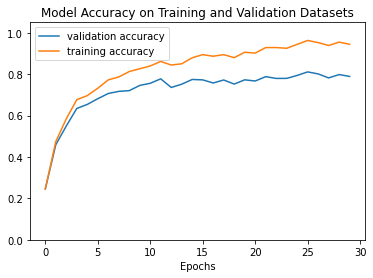

In [ ]:
# Plotting training accuracy and validation accuracy over time
plt.plot(validation_accuracy, label = "validation accuracy")
plt.plot(training_accuracy, label = "training accuracy")
plt.legend()
plt.xlabel('Epochs')
plt.title('Model Accuracy on Training and Validation Datasets')
plt.ylim((0,1.05))


<function matplotlib.pyplot.show>

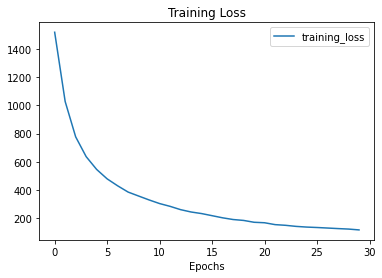

In [ ]:
# Plotting the training loss over time
plt.plot(training_loss,label = 'training_loss')
plt.legend()
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.show

### Evaluation (30 Epochs) 
----

The following hyper-parameters have been adjusted to try to improve performance of the neural network: 
* Number of convolutional layers 
* Number of channels 
* Batch Size 
* Learning Rate 
* Weight Decay

For each variant the training and validation losses are plotted using the cells below. 

Selection of the best model is dependent on the validation accuracy only, however the training accuracy is available to identify indications of over or underfitting. 

|Description| Conv Layers | # Channels | Batch Size | Learning Rate | Weight Decay | Training Accuracy | Validation Accuracy | 
|--------|-------------|------------|-------------|--------------|------------|--|--|
|Baseline| 2           |  L1: 6, L2:10| 32 | 0.01 | 0.001 |   1.0   | 0.73     |
| Increased weight decay to reduce overfitting | 2 |  L1: 6, L2:10| 32 | 0.01 | 0.005 |   0.95   |  0.70   |
| Further increase of weight decay | 2 |  L1: 6, L2:10| 32 | 0.01 | 0.008 |  0.95    |   0.70  |
| Further increase of weight decay | 2 |  L1: 6, L2:10| 32 | 0.01 | 0.01 |  0.96    |   0.72  |
| Increase of batch size | 2 |  L1: 6, L2:10| 128 | 0.01 | 0.01 |  0.86    |   0.65  |
| Reduced number of channels (original batch size) | 2 |  L1: 6, L2:8| 32 | 0.01 | 0.01 |  0.84    |   0.64  |
| Additional conv layer | 3 |  L1: 6, L2:8, L3:16| 32 | 0.01 | 0.01 |  0.89    |   0.75  |
| Change in channel numbers| 3 |  L1: 6, L2:12, L3:24| 32 | 0.01 | 0.01 |  0.89    |   0.73  |
| Change in channel numbers| 3 |  L1: 6, L2:24, L3:64| 32 | 0.01 | 0.01 | 0.94    | 0.74   |
| Change in channel numbers| 3 |  L1: 12, L2:32, L3:64| 32 | 0.01 | 0.01 | 0.96    | 0.77   |
| Reduced learning rate| 3 |  L1: 6, L2:12, L3:24| 32 | 0.001 | 0.01 |  0.68    |   0.61  |
| Change to Adam Optimizer (previously SGD). *NB. Seems to fail to converge*| 3 |  L1: 6, L2:12, L3:24| 32 | 0.01 | 0.01 |  0.43    |   0.42  |
| Lower learning rate, higher number of epochs (50)| 3 |  L1: 12, L2:32, L3:64| 32 | 0.001 | 0.01 |  0.86    |   0.69  |


## Application for the trained model (IVR)
----- 
In the next section a potential use of the trained model is proposed for a system which automatically detects mobile numbers read out to an Interactive Voice Response (IVR) system. 

* In this system a user is prompted to provide their mobile number to be saved by the system. 
* The trained model then takes the audio of each individual numeral (0-9) and predicts what was said by the user 
* The user is then prompted to review the recognised number to confirm it has been captured correctly
* An additional consideration which would need to be made is if users state groups of numerals as non-single digit numbers (e.g. the two digits 73 in a mobile number sequence could be read as "7","3" or "73"). 
  * This is not covered in this initial model. 

### Demonstration 
---
* For demonstration purposes a random mobile number is generated using a function. Each mobile number starts with "07" and is followed by 9 random digits. 
* From the mobile number generated audio files are selected at random from the MLEnd dataset. 
* In a real world application an additional step would be required to split the audio into individual segments for each numeral spoken.   
* A function provided in the cells below demonstrates how a potential interaction with the IVR could work.

In [ ]:
# Grouping samples of audio files for individual digits 
# These will be sampled randomly to generate example audio files for recognition
indices_0 = np.where(y_adv ==0)[0].tolist()
indices_1 = np.where(y_adv ==1)[0].tolist()
indices_2 = np.where(y_adv ==2)[0].tolist()
indices_3 = np.where(y_adv ==3)[0].tolist()
indices_4 = np.where(y_adv ==4)[0].tolist()
indices_5 = np.where(y_adv ==5)[0].tolist()
indices_6 = np.where(y_adv ==6)[0].tolist()
indices_7 = np.where(y_adv ==7)[0].tolist()
indices_8 = np.where(y_adv ==8)[0].tolist()
indices_9 = np.where(y_adv ==9)[0].tolist()

print("Number of audio samples available for selection of each digit:")
for i in range(10): 
  print(str(i) + ":", len(locals()['indices_'+str(i)]))

Number of audio samples available for selection of each digit:
0: 655
1: 663
2: 652
3: 650
4: 641
5: 650
6: 668
7: 638
8: 653
9: 663


In [ ]:
def generate_mobile_number(): 
  " A function for randomly generating a mobile number, starting with '07' followed by 9 other digits"
  mobile_number = [0,7]
  for i in range(9): 
    mobile_number.append(random.randint(0,9))
  
  print("Random Mobile Number Generated: ", end = " ")
  for i in mobile_number: 
    print(i, end = "")
  print("")
  return mobile_number
mobile_number = generate_mobile_number()

Random Mobile Number Generated:  07256263079


In [ ]:
def getXy_mfcc_IVR(file,scale_audio=True):
  " Slight variation of previous function to get MFCC features for a single audio file"
  X,y =[],[]
  full_dataset = []
  
  fs = None # if None, fs would be 22050
  x, fs = librosa.load(file,sr=fs)
  if scale_audio: x = x/np.max(np.abs(x))

  #MFCC
  mfcc = librosa.feature.mfcc(y=x,sr=fs)
  
  # Sample size 
  sample_size = 100

  # Padding / Clipping returned MFCC
  if mfcc.shape[1] < sample_size:
    mfcc_shape = np.shape(mfcc)
    mfcc_tx =  np.zeros((20,sample_size)) 
    mfcc_tx[:mfcc_shape[0], :mfcc_shape[1]] = mfcc
    #print("PADDING")
  else: 
    mfcc_tx = mfcc[:,:sample_size]
    #print("CLIPPING")


  mfcc_tx = np.matrix.transpose(mfcc_tx)

  xi = [mfcc_tx]
  X.append(xi)
  return np.array(X)

In [ ]:
def generate_demo_audio_features(mobile_number):
  """ 
  A function to be used for demonstration purposes. 
  An audio version of a mobile number is created by randomly sampling the features generated from the MLEnd dataset
  """ 
  # Looping through every number in the randomly generated mobile number 
  for j,i in enumerate(mobile_number): 
    # Selecting a random audio clip to extract features from the MLEnd dataset
    index = random.choice(globals()["indices_" + str(i)])
    
    display(ipd.Audio(files[index])) # Providing evidence of the files used in the demonstration

    # Extracting features
    single_sample = getXy_mfcc_IVR(files[index])
    
    # Joining all numbers to be classified by the model 
    if j == 0: 
      full_number = torch.tensor(single_sample)
    else:
      single_sample = torch.tensor(single_sample)
      full_number = torch.cat((full_number,single_sample))

  return full_number


full_number = generate_demo_audio_features(mobile_number)

In [ ]:
def predict_mobile_number(X): 
  " A function which takes extracted audio features for a spoken mobile number and predicts the stated digits "
  
  # Predicting the digits using the model
  y_hat = model(X.float())
  
  # Returning the index of the maximum value of y_hat to get the predicted digit
  y_hat_values, y_hat_indices  = torch.max(y_hat,1)
  
  # Returning the values as a list
  predicted_number = [i.item() for i in y_hat_indices]
  
  return predicted_number
  
  
predict_mobile_number(full_number)

[0, 7, 2, 4, 6, 2, 6, 3, 0, 7, 9]

In [ ]:
def IVR(): 
  " A function which demonstrates a possible use of the trained model in an IVR scenario"
  print("Hello, please read out your mobile number to be saved by our system")

  # In practice this section would be replaced by a mobile number spoken by the user  
  mobile_number = generate_mobile_number()
  full_number = generate_demo_audio_features(mobile_number)  # Extracting features included here
  # An additional step to split the spoken numerals into individual segments would also be required
  
  # Feeding the features extracted from audio files into the model
  predicted_number = predict_mobile_number(full_number)

  complete = False
  # Interaction with the user to ensure data is accurately collected
  while complete == False:      
    print("\nMobile Number Detected: ", end ="\n")
    # Printing out the mobile number predicted by the model
    for i in predicted_number: 
      print(i, end = "")
    
    # Allow the user to confirm predictions 
    print("\n Is this correct? Y/N")
    input_value = input()
    if(input_value.lower() == "y"):
      print("\nThank you, your number has been saved") 
      complete = True
      # If numbers are confirmed as correct then the model can continue to gather labelled data to improve future performance 
    else: 
      # Ask the user to repeat the number if prediction was incorrect
      print("\nPlease repeat your mobile number")
      full_number = generate_demo_audio_features(mobile_number)
      predicted_number = predict_mobile_number(full_number)

  return predicted_number

In [ ]:
# A demonstration of the use case
saved_number = IVR() 

Hello, please read out your mobile number to be saved by our system
Random Mobile Number Generated:  07471816548



Mobile Number Detected: 
07471816548
 Is this correct? Y/N
Y

Thank you, your number has been saved


## Conclusion 
---- 
The use of a convolutional neural network to identify features useful for classification of numerals has been effective as demonstrated by a peak validation accuracy of c. 77%. 

The parameters of the final convolutional neural network used are as follows: 

| Conv Layers | # Channels | Batch Size | Learning Rate | Weight Decay | Training Accuracy | Validation Accuracy | # Epochs | 
|-------------|------------|-------------|--------------|------------|--|--| --|
| 3 |  L1: 12, L2:32, L3:64| 32 | 0.01 | 0.01 | 0.96    | 0.77   | 30| 


This section has also demonstrated a potential usecase for the model once it has been trained by showing how it could be used in an IVR scenario. In reality the accuracy achieved by the model may not be sufficient for real-world deployment, further enhancements would likely be required. 